In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Look At Columns in Tables
inspector = sqlalchemy.inspect(engine)
columns_in_measurement = inspector.get_columns('Measurement')
for c in columns_in_measurement:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Look At Columns in Tables
inspector = sqlalchemy.inspect(engine)
columns_in_station = inspector.get_columns('Station')
for c in columns_in_station:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
query_result = engine.execute('SELECT * FROM measurement ORDER BY measurement.date desc LIMIT 1').fetchall()
last_date_in_data = query_result[0][2]
start_date_of_query = dt.datetime.strptime(last_date_in_data, '%Y-%m-%d') - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
query_result = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= start_date_of_query).order_by(Measurement.date).all()
query_result

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

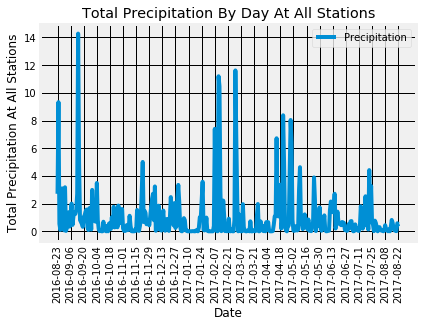

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(query_result).set_index('date')

# Sort the dataframe by date
precip_df.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
# Drop NAs
precip_df = precip_df.dropna()
precip_df_by_day = pd.DataFrame(precip_df.groupby(['date'])['prcp'].sum()) 
x = precip_df_by_day.index.values.tolist()
y = precip_df_by_day['prcp']
plt.plot(x,y,label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Total Precipitation At All Stations')
plt.title('Total Precipitation By Day At All Stations')
plt.xticks(np.arange(0, len(x),step=14),rotation=90)
plt.grid(color='black')
plt.legend(loc='upper right')
plt.show()

![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [15]:
# Design a query to show how many stations are available in this dataset?
query_result = session.query(Measurement.station).distinct().all()
query_result

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
query_result = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
query_result

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# What are the least active stations? (i.e. what stations have the fewest rows)?
# List the stations and the counts in ascending order.
query_result = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).asc()).all()
query_result

[('USC00518838', 511),
 ('USC00517948', 1372),
 ('USC00511918', 1979),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00519523', 2669),
 ('USC00513117', 2709),
 ('USC00519397', 2724),
 ('USC00519281', 2772)]

In [18]:
# Most and Least Active Stations
least_active_station = query_result[0][0]
most_active_station = query_result[len(query_result)-1][0]
most_active_station

'USC00519281'

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
query_result = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).group_by(Measurement.station).all()
query_result

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Get Data
query_result = session.query(Measurement.date, Measurement.station, Measurement.tobs).filter(Measurement.date >= start_date_of_query, Measurement.station == most_active_station).all()
temp_df = pd.DataFrame(query_result).set_index('date')
temp_df.head()

,station,tobs
date,,
2016-08-23,USC00519281,77.0
2016-08-24,USC00519281,77.0
2016-08-25,USC00519281,80.0
2016-08-26,USC00519281,80.0
2016-08-27,USC00519281,75.0


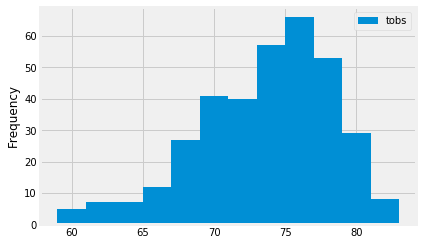

In [21]:
# Make Plot
plt.hist(temp_df['tobs'], label='tobs', bins=12)
temp_df.head()
plt.ylabel('Frequency')
plt.legend(loc='upper right')

![precipitation](Images/station-histogram.png)

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2016-12-15'
trip_end = '2016-12-31'

start_date_of_query = dt.datetime.strptime(trip_start, '%Y-%m-%d') - dt.timedelta(days=366)
end_date_of_query = dt.datetime.strptime(trip_end, '%Y-%m-%d') - dt.timedelta(days=366)
start_date_of_query = dt.datetime.strftime(start_date_of_query, '%Y-%m-%d')
end_date_of_query = dt.datetime.strftime(end_date_of_query, '%Y-%m-%d')

# Call Function
temps = calc_temps(start_date_of_query, end_date_of_query)
temps

[(67.0, 73.67676767676768, 82.0)]

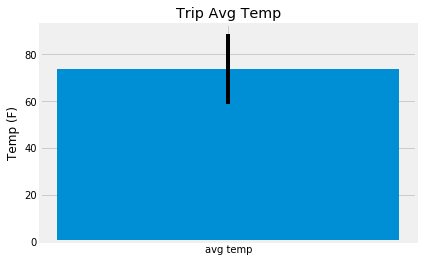

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_temp = temps[0][0]
avg_temp = temps[0][1]
max_temp = temps[0][2]

plt.bar('avg temp', avg_temp, yerr = max_temp-min_temp)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.show()

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
query_result = session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation).\
join(Measurement, Measurement.station==Station.station).\
filter(Measurement.date >= start_date_of_query, Measurement.date <= end_date_of_query).\
group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

precip_df = pd.DataFrame(query_result, columns= ['Station', 'Precip Total', 'Station Name', 'Lat', 'Long', 'Elevation'])
precip_df

,Station,Precip Total,Station Name,Lat,Long,Elevation
0,USC00516128,8.62,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,3.80,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,3.00,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519523,1.66,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,USC00514830,0.89,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00519397,0.81,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,0.11,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
print(trip_start)
print(trip_end)

# Use the start and end date to create a range of dates
trip_range = pd.date_range(start = trip_start, end = trip_end, freq = 'D')

# Stip off the year and save a list of %m-%d strings
trip_strings = []

for trip_day in trip_range:
    if trip_day.month < 10:
        trip_string_m = '0' + str(trip_day.month) 
    else:
        trip_string_m = str(trip_day.month)
    if trip_day.day < 10:
        trip_string_d = '0' + str(trip_day.day)
    else:
        trip_string_d = str(trip_day.day)
    trip_string = trip_string_m + '-' + trip_string_d    
    trip_strings.append(trip_string)

# Loop through the list of %m-%d strings and calculate the normals for each date
for trip_string in trip_strings:
    normals.append(daily_normals(trip_string)[0])
normals

2016-12-15
2016-12-31


[(62.0, 71.34, 79.0),
 (60.0, 69.62264150943396, 82.0),
 (63.0, 70.64, 77.0),
 (63.0, 71.28, 77.0),
 (67.0, 72.0, 78.0),
 (65.0, 72.91304347826087, 81.0),
 (67.0, 72.13953488372093, 78.0),
 (67.0, 71.1304347826087, 77.0),
 (61.0, 70.34693877551021, 78.0),
 (62.0, 70.0625, 78.0),
 (60.0, 71.75, 79.0),
 (63.0, 71.44680851063829, 77.0),
 (62.0, 71.91666666666667, 79.0),
 (62.0, 70.52083333333333, 77.0),
 (57.0, 70.29166666666667, 78.0),
 (63.0, 69.86363636363636, 76.0),
 (56.0, 68.27906976744185, 77.0)]

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ['min','avg','max'])
normals_df['date'] = pd.to_datetime(trip_range)
normals_df.set_index('date')

,min,avg,max
date,,,
2016-12-15,62.0,71.340000,79.0
2016-12-16,60.0,69.622642,82.0
2016-12-17,63.0,70.640000,77.0
2016-12-18,63.0,71.280000,77.0
2016-12-19,67.0,72.000000,78.0
2016-12-20,65.0,72.913043,81.0
2016-12-21,67.0,72.139535,78.0
2016-12-22,67.0,71.130435,77.0
2016-12-23,61.0,70.346939,78.0


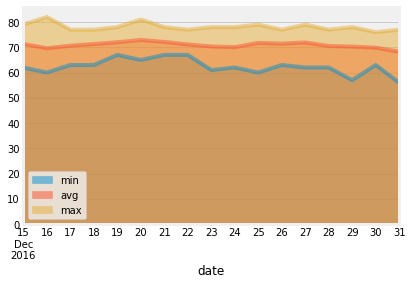

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
plt = normals_df.plot.area(x='date',stacked=False)